<a href="https://colab.research.google.com/github/khushipanchal0108/DCGANS_CelebaData/blob/main/DCGANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Khushi Panchal

22070126055

AIML A3

### **Theory for DCGAN Experiment**
**Deep Convolutional Generative Adversarial Networks (DCGANs)** are a type of GAN that use deep convolutional layers instead of fully connected layers. They were introduced by **Radford et al. (2015)** in the paper **"Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks."**  

#### **Objective**
The goal of this experiment is to train a **DCGAN** to generate realistic images using either the **LSUN Bedrooms dataset** or the **CelebA Faces dataset**. The generator learns to create fake images that resemble real images, while the discriminator learns to distinguish real images from fake ones.  

#### **How DCGAN Works**
DCGAN consists of two neural networks:  

1. **Generator (G):**  
   - Takes a **random noise vector (latent space)** as input.  
   - Transforms it into an image using **transpose convolution (upsampling).**  
   - Outputs a synthetic (fake) image.  

2. **Discriminator (D):**  
   - Takes an image (either real or fake) as input.  
   - Uses **convolutional layers** to classify the image as real or fake.  
   - Outputs a probability score (1 for real, 0 for fake).  

#### **Training Process**
1. The **generator** creates fake images from random noise.  
2. The **discriminator** classifies images as real or fake.  
3. Both models update their parameters using **backpropagation**:  
   - **Discriminator loss:** How well it distinguishes real vs. fake images.  
   - **Generator loss:** How well it fools the discriminator.  
4. Over time, the generator improves, producing more realistic images.  

#### **Why DCGAN?**
- Uses **convolutions** instead of fully connected layers (better for images).  
- Avoids pooling layers by using **strided convolutions** (preserves spatial information).  
- Uses **batch normalization** for stable training.  
- Uses **LeakyReLU and ReLU activations** for better gradient flow.  



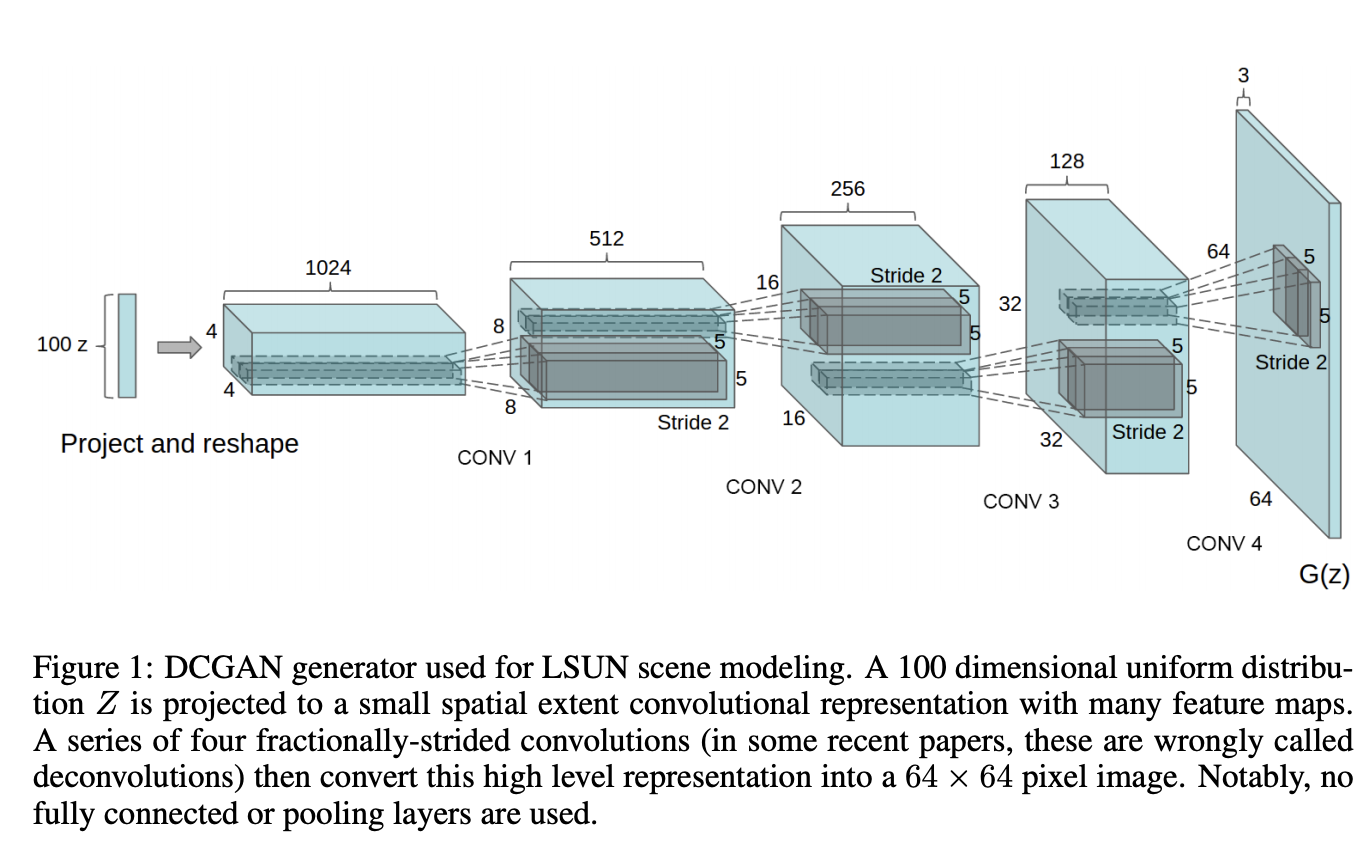

In [ ]:
pip install torch torchvision matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


# DCGAN Implementation in PyTorch

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # for showing progress bar during training

In [ ]:
import os
import zipfile

# move kaggle.json to the right folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download celeba dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

# extract the dataset
with zipfile.ZipFile("celeba-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("data")


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100%|██████████████████████████████████████▊| 1.33G/1.33G [00:09<00:00, 175MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:09<00:00, 146MB/s]


In [ ]:
# Hyperparameters & Configuration
dataset = "CelebA"  # choose between "CelebA" or "LSUN"
image_size = 64  # size of the generated images
batch_size = 64  # number of images per batch
latent_dim = 100  # size of the input noise vector
features_gen = 64  # number of generator feature maps
features_disc = 64  # number of discriminator feature maps
epochs = 20  # total number of training epochs
learning_rate = 0.0005  # learning rate for optimizers
beta1 = 0.5  # beta1 hyperparameter for Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# define data transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize(image_size),  # resize images to 64x64
    transforms.CenterCrop(image_size),  # crop center part of image
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalize pixel values to [-1,1] for stable training
])

In [ ]:
# load dataset
dataset = torchvision.datasets.ImageFolder(root="data/img_align_celeba", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# define generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, features_gen):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input: latent_dim x 1 x 1 -> output: features_gen * 8 x 4 x 4
            nn.ConvTranspose2d(latent_dim, features_gen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_gen * 8),
            nn.ReLU(True),

            # output: features_gen * 4 x 8 x 8
            nn.ConvTranspose2d(features_gen * 8, features_gen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 4),
            nn.ReLU(True),

            # output: features_gen * 2 x 16 x 16
            nn.ConvTranspose2d(features_gen * 4, features_gen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 2),
            nn.ReLU(True),

            # output: features_gen x 32 x 32
            nn.ConvTranspose2d(features_gen * 2, features_gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen),
            nn.ReLU(True),

            # output: 3 x 64 x 64 (rgb image)
            nn.ConvTranspose2d(features_gen, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
# create generator
generator = Generator(latent_dim, features_gen).to(device)

In [ ]:
# define discriminator network
class Discriminator(nn.Module):
    def __init__(self, features_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: 3 x 64 x 64 -> output: features_disc x 32 x 32
            nn.Conv2d(3, features_disc, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # output: features_disc * 2 x 16 x 16
            nn.Conv2d(features_disc, features_disc * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_disc * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # output: features_disc * 4 x 8 x 8
            nn.Conv2d(features_disc * 2, features_disc * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_disc * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # output: features_disc * 8 x 4 x 4
            nn.Conv2d(features_disc * 4, features_disc * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_disc * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # output: single value (real/fake classification)
            nn.Conv2d(features_disc * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
# create discriminator
discriminator = Discriminator(features_disc).to(device)

In [ ]:
# define loss function and optimizers
criterion = nn.BCELoss()
optimizer_gen = optim.AdamW(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_disc = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [ ]:
# training loop
print("starting training...")

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(dataloader)):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # create real and fake labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # train discriminator on real images
        optimizer_disc.zero_grad()
        real_output = discriminator(real_images).view(-1)
        loss_real = criterion(real_output, real_labels)

        # generate fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(fake_output, fake_labels)

        # compute total discriminator loss
        loss_disc = loss_real + loss_fake
        loss_disc.backward()
        optimizer_disc.step()

        # train generator
        optimizer_gen.zero_grad()
        fake_output = discriminator(fake_images).view(-1)
        loss_gen = criterion(fake_output, real_labels)  # generator tries to fool the discriminator
        loss_gen.backward()
        optimizer_gen.step()

    print(f"epoch [{epoch+1}/{epochs}] | d loss: {loss_disc.item():.4f} | g loss: {loss_gen.item():.4f}")

    # save generated images
    with torch.no_grad():
        fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)
        fake_images = generator(fixed_noise)
        vutils.save_image(fake_images, f"generated_epoch_{epoch+1}.png", normalize=True)



starting training...


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [1/20] | d loss: 0.5124 | g loss: 6.2836


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [2/20] | d loss: 0.1599 | g loss: 5.6751


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [3/20] | d loss: 0.1633 | g loss: 3.5788


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [4/20] | d loss: 0.2530 | g loss: 5.9520


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [5/20] | d loss: 0.0882 | g loss: 5.5763


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [6/20] | d loss: 0.4924 | g loss: 8.4688


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [7/20] | d loss: 0.1033 | g loss: 6.6585


100%|██████████| 3166/3166 [06:23<00:00,  8.24it/s]


epoch [8/20] | d loss: 0.1219 | g loss: 6.1184


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [9/20] | d loss: 0.7688 | g loss: 2.7788


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [10/20] | d loss: 0.5956 | g loss: 7.6089


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [11/20] | d loss: 0.0691 | g loss: 5.4232


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [12/20] | d loss: 0.1279 | g loss: 6.1801


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [13/20] | d loss: 0.0445 | g loss: 5.7695


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [14/20] | d loss: 0.0617 | g loss: 5.7130


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [15/20] | d loss: 0.0386 | g loss: 6.5888


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [16/20] | d loss: 0.1668 | g loss: 3.6370


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [17/20] | d loss: 0.1638 | g loss: 8.0075


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [18/20] | d loss: 0.0142 | g loss: 6.1022


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [19/20] | d loss: 0.1627 | g loss: 6.9171


100%|██████████| 3166/3166 [06:23<00:00,  8.25it/s]


epoch [20/20] | d loss: 0.5876 | g loss: 5.1301


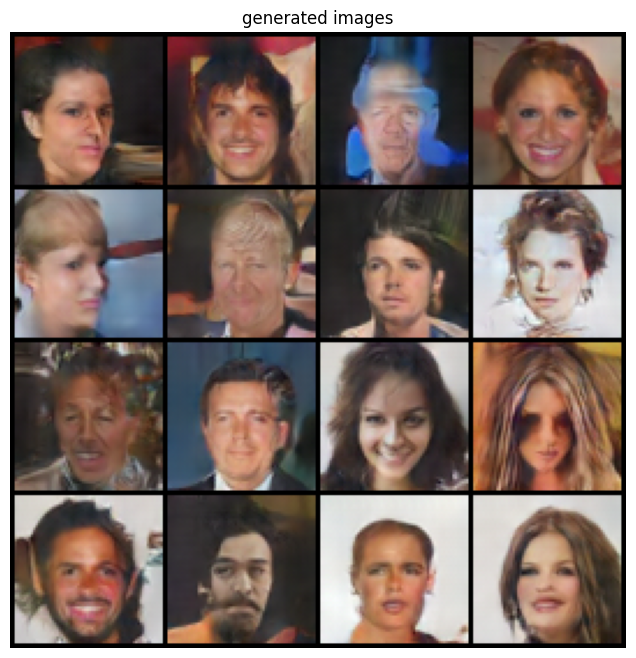

In [ ]:
# function to generate and display images
def generate_images(num_images=16):
    generator.eval()
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise)

    grid = vutils.make_grid(generated_images, nrow=4, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("generated images")
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.show()

generate_images()

GITHUB:

https://github.com/khushipanchal0108/DCGANS_CelebaData